In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

### imports

In [16]:
print(__doc__)

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from tqdm.notebook import tqdm
from sklearn.cluster import KMeans
from sklearn.utils.extmath import softmax
from sklearn.preprocessing import normalize
from sklearn.datasets import fetch_20newsgroups
from scipy.stats import entropy as calculate_entropy
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer

Automatically created module for IPython interactive environment


### utilities

In [17]:
def sigmoid(x):
    return 1 / (1 + (np.e**-x))

def infer_topic(label_classes, doc_vector, topic_word_distr):
    doc_topic_word_distr = topic_word_distr.copy()

    for label_class in label_classes:
        doc_topic_word_distr[label_class] *= doc_vector
    
    
    doc_topic = np.max(doc_topic_word_distr).idxmax()
    return doc_topic_word_distr, doc_topic

### load dataset

In [18]:
# total number of samples needed
datasize = 150
randomize = False

# retrieve dataset
categories = ['rec.autos', 'talk.religion.misc', 'comp.graphics', 'sci.space']
label_classes = ['autos', 'religion', 'graphics', 'space']

assert len(label_classes) == len(categories)

docs = fetch_20newsgroups(subset='train', shuffle=randomize, remove=('headers', 'footers', 'quotes'), categories=categories)
docs, old_labels, classes = docs.data, docs.target, docs.target_names

### clean dataset

In [19]:
# clean out the new line characters from text in docs
def clean_doc(doc):
    ''' remove unwanter characters line new line '''

    unwanted_chrs = [')', '(', '{', '}', '\t', '\n', '\r', "'", '"', "!"]
    doc = doc.lower()
    for unwanted_chr in unwanted_chrs:
        doc = doc.replace(unwanted_chr, ' ')

    return doc.strip()

In [20]:
labels = []
clean_docs = []
max_document_length = None

# the new classes
sizes = [0] * len(label_classes)
assert len(label_classes) == len(sizes)

for index, doc in enumerate(docs):
    if len(clean_docs) == datasize*len(label_classes):
        break
        
    cd = clean_doc(doc)
    
    if len(cd) == 0 or cd.isspace() or (max_document_length is not None and len(cd) <= max_document_length):
        continue
        
    label_class = classes[old_labels[index]]
    label = categories.index(label_class)

    if sizes[label] < datasize:
        clean_docs.append(cd)
        labels.append(label)

        sizes[label] += 1

labels = np.array(labels)
print(clean_docs[0])

<apparently you re not a woman - my husband hates the auto door locks <feels safer in a car that locks easily  in addition to watching around <in a secluded spot, etc - have my keys ready to open the door so i m


In [21]:
print(f"there are {len(clean_docs)} docs and {len(label_classes)} classes: {label_classes} of size min:{min(sizes)}, max:{max(sizes)}")

there are 600 docs and 4 classes: ['autos', 'religion', 'graphics', 'space'] of size min:150, max:150


### count words

In [22]:
# initialize the count vectorizer
count_vectorizer = CountVectorizer()
# count_vectorizer = TfidfVectorizer()

# fit it to dataset
train_docs, test_docs, train_labels, test_labels = train_test_split(clean_docs, labels, test_size=.33, random_state=42)
count_vectorizer.fit(train_docs)
vocabulary = count_vectorizer.get_feature_names()

print("word_count is", len(vocabulary))

word_count is 10370


### Prepare Datatset

In [23]:
# create doc count vectors
train_doc_vectors = count_vectorizer.transform(train_docs).toarray()
# train_doc_vectors = (train_doc_vectors > 0).astype(float)
train_doc_vectors = normalize(train_doc_vectors, norm="l1", axis=1)

test_doc_vectors = count_vectorizer.transform(test_docs).toarray()
# test_doc_vectors = (test_doc_vectors > 0).astype(float)
test_doc_vectors = normalize(test_doc_vectors, norm="l1", axis=1)

print(f"{len(train_labels)} train_docs, {len(test_labels)} test docs")

402 train_docs, 198 test docs


In [24]:
document_word_frequency = pd.DataFrame(train_doc_vectors, columns=count_vectorizer.get_feature_names())
document_word_frequency["__labels__"] = train_labels

print("document_word_frequency shape is", document_word_frequency.shape)

document_word_frequency shape is (402, 10371)


In [25]:
print(f"there are {len(clean_docs)} docs and {len(label_classes)} classes")

there are 600 docs and 4 classes


In [26]:
document_word_frequency.head()

,00,000,0029,01,01a,02,03,04,04110,05,...,zooms,zorn,zoroaster,zoroastrian,zoroastrianism,zoroastrians,zubin,zuck,zulu,__labels__
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0


### Prepare Binary Dataset

In [27]:
#reduce freq in doc to bin value of 1 or 0
word_doc_freqency = document_word_frequency.drop(["__labels__"], axis='columns')

#the sum vertically of bin freq
word_doc_total_frequency = word_doc_freqency.sum(0)

### Word and Word corelation

In [ ]:
word_word_co = pd.DataFrame(data=0.0, columns=vocabulary, index=vocabulary)

for word_index in tqdm(range(len(vocabulary))):
    word = vocabulary[word_index]

    word_word_frequency = word_doc_freqency[word_doc_freqency[word] > 0].sum(0)
    trust_factor = sigmoid((word_doc_freqency > 0).sum(0))
    
    word_word_co[word] = ((word_word_frequency * trust_factor) / word_doc_total_frequency).fillna(0)

# word_word_co = word_word_co.T
# entropy = np.nan_to_num(calculate_entropy(word_word_co, base=2))
# word_word_co = (word_word_co * (np.e**(-entropy**2)))
print(f"word_word_co has shape {word_word_co.shape}")

In [47]:
word_word_co.head()

,00,000,0029,01,01a,02,03,04,04110,05,...,zooming,zooms,zorn,zoroaster,zoroastrian,zoroastrianism,zoroastrians,zubin,zuck,zulu
00,1.299210e-28,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.0,0.0,0.000000e+00,0.0,0.000000e+00,...,0.0,0.0,0.0,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.0,0.0
000,0.000000e+00,2.005129e-40,0.000000e+00,0.000000e+00,0.000000e+00,0.0,0.0,0.000000e+00,0.0,0.000000e+00,...,0.0,0.0,0.0,8.878839e-31,8.878839e-31,8.878839e-31,8.878839e-31,8.878839e-31,0.0,0.0
0029,0.000000e+00,0.000000e+00,8.509653e-27,2.373164e-28,0.000000e+00,0.0,0.0,8.509653e-27,0.0,8.509653e-27,...,0.0,0.0,0.0,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.0,0.0
01,0.000000e+00,0.000000e+00,3.347155e-28,3.092248e-28,1.311975e-07,0.0,0.0,3.347155e-28,0.0,3.347155e-28,...,0.0,0.0,0.0,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.0,0.0
01a,0.000000e+00,0.000000e+00,0.000000e+00,2.373164e-28,1.477472e-07,0.0,0.0,0.000000e+00,0.0,0.000000e+00,...,0.0,0.0,0.0,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.0,0.0


In [59]:
word = "computer"
words = ["applications", "the", "and", "software", "party"]
word_word_co[word].sort_values(ascending=False)

computer      1.362128e-54
jpl           1.337629e-54
atmosphere    1.297528e-54
principal     1.297528e-54
acronym       1.297528e-54
                  ...     
lebanese      0.000000e+00
lebanon       0.000000e+00
leberle       0.000000e+00
lecturer      0.000000e+00
holding       0.000000e+00
Name: computer, Length: 10370, dtype: float64

In [62]:
word_word_co[word].values.max()

1.3621284017613592e-54

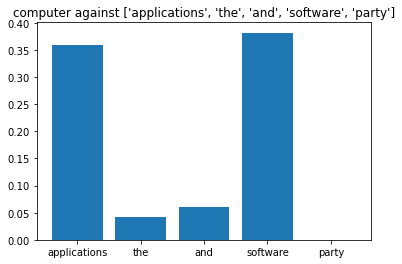

In [61]:
plt.title(f"{word} against {words}")
plt.bar(words, word_word_co[word][words] / word_word_co[word].values.max())
plt.show()

### Topic and word corelation

In [73]:
kmeans_model = KMeans(n_clusters=len(label_classes), random_state=0)
dist = kmeans_model.fit_transform(word_word_co.T)

In [74]:
t1 = dist[:, 0]
np.array(vocabulary)[t1.argsort()[::-1]][:20]

array(['vpic60', 'ultrix', '_perijoves_', 'conform', 'calibra', 'buggy',
       'graphigs', 'radon', 'crt', 'varieties', 'photosynthetic',
       '_incredibly_', 'bored', 'audio', 'listings', 'biscayne', 'bel',
       'gonna', 'palm', 'lemur'], dtype='<U71')

In [75]:
t2 = dist[:, 1]
np.array(vocabulary)[t2.argsort()[::-1]][:20]

array(['vpic60', '_perijoves_', 'conform', 'calibra', 'buggy', 'graphigs',
       'radon', 'crt', 'photosynthetic', 'varieties', 'bored',
       '_incredibly_', 'audio', 'listings', 'palm', 'lemur', 'gonna',
       'biscayne', 'bel', 'wwhite'], dtype='<U71')

In [76]:
t3 = dist[:, 2]
np.array(vocabulary)[t3.argsort()[::-1]][:20]

array(['ultrix', '_perijoves_', 'conform', 'calibra', 'buggy', 'radon',
       'crt', 'photosynthetic', 'varieties', 'bored', '_incredibly_',
       'graphigs', 'audio', 'listings', 'bel', 'biscayne', 'gonna',
       'palm', 'lemur', 'flag'], dtype='<U71')

In [77]:
t4 = dist[:, 3]
np.array(vocabulary)[t4.argsort()[::-1]][:20]

array(['vpic60', 'ultrix', 'conform', 'calibra', 'buggy', 'graphigs',
       'radon', 'crt', 'photosynthetic', 'varieties', 'bored',
       '_incredibly_', 'audio', 'listings', 'gonna', 'biscayne', 'bel',
       'palm', 'lemur', 'wwhite'], dtype='<U71')

In [19]:
topic_word_distr = pd.DataFrame(data=0.0, columns=label_classes, index=vocabulary)

for topic, label in enumerate(label_classes):
    word_topic_frequency = word_doc_binary_freqency[document_word_frequency['__labels__'] == topic].sum(0)
    trust_factor = sigmoid(word_doc_frequency)
    
    topic_word_distr[label] = ((word_topic_frequency * trust_factor) / word_doc_frequency).fillna(0)
    
print(f"topic_word_distr has shape {topic_word_distr.shape}")

topic_word_distr has shape (4973, 2)


In [20]:
topic_word_distr.head()

,sci/comp,other
00,0.0,0.500032
000,0.0,0.500502
0188,0.0,0.500134
02026,0.0,0.500134
0837,0.0,0.500134


In [21]:
word = "companies"
topic_word_distr.loc[word].sort_values(ascending=False)

other       0.500883
sci/comp    0.000000
Name: companies, dtype: float64

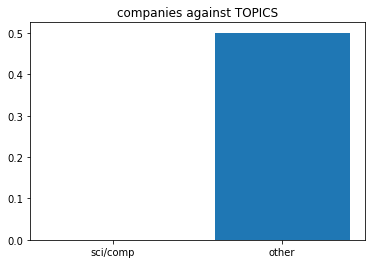

In [22]:
plt.title(f"{word} against TOPICS")
plt.bar(topic_word_distr.loc[word].index, topic_word_distr.loc[word])
plt.show()

### Evaluating Topic Model

In [23]:
score = 0
misclassified_train = []
print("Evaluating Topic Model...")
for doc_index in tqdm(range(len(train_labels))):
    doc_vector = train_doc_vectors[doc_index]
    
    doc_topic_word_distr, doc_topic = infer_topic(doc_vector, topic_word_distr, 0)
    score += int(doc_topic == label_classes[train_labels[doc_index]])
    
    if doc_topic != label_classes[train_labels[doc_index]]:
        misclassified_train.append(doc_index)

train_accuracy = score / (doc_index + 1)
print(f"==> train-accuracy is {train_accuracy*100:.2f}%\n")

Evaluating Topic Model...



==> train-accuracy is 100.00%



In [210]:
index = 0
label = label_classes[train_labels[misclassified_train[index]]]
doc_vector = train_doc_vectors[misclassified_train[index]]
doc_topic_word_distr, doc_topic = infer_topic(doc_vector, topic_word_distr, 0)

print(f"predicted = {doc_topic}, actual = {label}")
print("="*50)
print(clean_docs[misclassified_train[index]])
doc_topic_word_distr.loc[doc_topic_word_distr.sum(1).sort_values(ascending=False).index]
# doc_topic_word_distr.sum(1).sort_values(ascending=False)

IndexError: list index out of range

### Testing Topic Model

In [211]:
score = 0
misclassified_test = []
print("Evaluating Topic Model...")
for doc_index in tqdm(range(len(test_labels))):
    doc_vector = test_doc_vectors[doc_index]
    
    doc_topic_word_distr, doc_topic = infer_topic(doc_vector, topic_word_distr, 0)
    score += int(doc_topic == label_classes[test_labels[doc_index]])
    
    if doc_topic != label_classes[test_labels[doc_index]]:
        misclassified_test.append(doc_index)

test_accuracy = score / (doc_index + 1)
print(f"==> test-accuracy is {test_accuracy*100:.2f}%\n")

Evaluating Topic Model...



==> test-accuracy is 100.00%

